In [3]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import Data

In [4]:
#INPUT
file_name = ['results','materials','conditioning','exposure']
file_path = '/Users/meddelinsetiawan/Library/CloudStorage/OneDrive-PrincetonUniversity/Documents/Classes/CBE512/dataset/'
#output_path = ''
header_row = 14 #header's line number in csv file

results_df = pd.read_csv(file_path+file_name[0]+'.csv', delimiter=',')
materials_df = pd.read_csv(file_path+file_name[1]+'.csv')
conditioning_df = pd.read_csv(file_path+file_name[2]+'.csv')
exposure_df = pd.read_csv(file_path+file_name[3]+'.csv')


# Pre-processing

### Results File

In [5]:
def calc_coefficient(h,t):
    '''
    Perform linear regression of results data points using Fick's diffusion law, and returns the carbonation coefficient
    
    h : carbonation depth
    t : time
    x_0 : carbonation coefficient 
    '''
    sqrt_t = np.sqrt(t).reshape(-1, 1)
    h = h.reshape(-1, 1)
    model = LinearRegression()
    model.fit(sqrt_t, h)
    x_0 = model.coef_[0][0]
    return x_0

def calc_depth(x_0,t):
    '''
    Returns the carbonation depth at a time point based on Fick's diffusion law
    t : time
    x_0 : carbonation coefficient
    '''
    return x_0*np.sqrt(t)

### Feature Space:


In [6]:
#Handle materials feature
print(materials_df.keys())

# Consolidate cement strength class and development into one categorical feature called "cement strength class"
materials_df['Cement Strength Class'] = materials_df['Cement Strength Class'].astype(str) + materials_df['Cement Strength Development']

# Truncate Cement Strength Development, max grain size, grading curve, and kNaC. 
columns_to_remove = ['Cement Strength Development',"Max Grain Size", "Grading Curve", "kNAC", "Unnamed: 14"]
materials_df = materials_df.drop(columns=columns_to_remove)
print(materials_df)

# Encode categorical labels: cement type, cement strength class, addition type, aggregate type, admixture type.
categorical_features = ['Cement Type', 'Cement Strength Class', 'Addition Type', 'Aggregate Type', 'Admixture Type']
ordinal_encoder = OrdinalEncoder(encoded_missing_value=-1)
materials_df[categorical_features] = ordinal_encoder.fit_transform(materials_df[categorical_features])

'''
# Make another materials df that contains only the features required by CarboDB developers
non_required_columns = ['Cement Strength Class','Cement Amount',
       'Addition Type', 'Addition Amount', 'Binder Amount', 'Aggregate Type',
       'Admixture Type']
materials_df_required = materials_df.drop(columns=non_required_columns)
print(materials_df_required.head())'''

for col, categories in zip(categorical_features, ordinal_encoder.categories_):
    print(f"Mapping for '{col}':")
    for category, encoding in zip(categories, range(len(categories))):
        print(f"  {category} -> {encoding}")
    print()

print(materials_df)
materials_df = materials_df.fillna(-1)
print(materials_df)

Index(['ID', 'Cement Type', 'Cement Strength Class',
       'Cement Strength Development', 'Cement Amount', 'Addition Type',
       'Addition Amount', 'Binder Amount', 'Aggregate Type', 'Admixture Type',
       'Max Grain Size', 'Grading Curve', 'wb ratio', 'kNAC', 'Unnamed: 14'],
      dtype='object')
      ID  Cement Type Cement Strength Class  Cement Amount Addition Type  \
0      1        CEM I                 42.5R          320.0           NaN   
1      2        CEM I                 42.5R          320.0           NaN   
2      3        CEM I                 42.5R          320.0           NaN   
3      4        CEM I                 42.5R          320.0           NaN   
4      5        CEM I                 42.5R          320.0           NaN   
..   ...          ...                   ...            ...           ...   
147  149  CEM II/B-LL                 32.5R          320.0           NaN   
148  150  CEM II/B-LL                 32.5R          320.0           NaN   
149  151  CE

In [7]:
#Handle conditioning features
print(conditioning_df)
conditioning_df = conditioning_df.fillna(-1)
print(conditioning_df)
'''

# Make another conditioning df that contains only the features required by CarboDB developers
non_required_columns = ['Demoulding Age', 'Curing Type',
       'Preconditioning Duration', 'Preconditioning Temperature',
       'Preconditioning RH', 'Preconditioning CO2', 'Standard Conditions']
conditioning_df_required = conditioning_df.drop(columns=non_required_columns)
print(conditioning_df_required.keys())
print(conditioning_df_required.head())
'''

      ID  Demoulding Age  Curing Type  Curing Duration  \
0      1             NaN          NaN                7   
1      2             NaN          NaN                7   
2      3             NaN          NaN                7   
3      4             NaN          NaN                7   
4      5             NaN          NaN                7   
..   ...             ...          ...              ...   
147  149             1.0          NaN               28   
148  150             1.0          NaN               28   
149  151             1.0          NaN               28   
150  152             1.0          NaN                1   
151  153             1.0          NaN                1   

     Preconditioning Duration  Preconditioning Temperature  \
0                         NaN                          NaN   
1                         NaN                          NaN   
2                         NaN                          NaN   
3                         NaN                          

"\n\n# Make another conditioning df that contains only the features required by CarboDB developers\nnon_required_columns = ['Demoulding Age', 'Curing Type',\n       'Preconditioning Duration', 'Preconditioning Temperature',\n       'Preconditioning RH', 'Preconditioning CO2', 'Standard Conditions']\nconditioning_df_required = conditioning_df.drop(columns=non_required_columns)\nprint(conditioning_df_required.keys())\nprint(conditioning_df_required.head())\n"

In [8]:
#Handle exposure features
print(exposure_df)

# Truncate 'Time 0 Carbonation Depth deviation' and 'Determination Method'. 
columns_to_remove = ['Time 0 Carbonation Depth deviation','Determination Method']
exposure_df = exposure_df.drop(columns=columns_to_remove)

# Encode categorical labels: cement type, cement strength class, addition type, aggregate type, admixture type.
categorical_features = ['Carbonation Type']
ordinal_encoder = OrdinalEncoder(encoded_missing_value=-1)
exposure_df[categorical_features] = ordinal_encoder.fit_transform(exposure_df[categorical_features])

for col, categories in zip(categorical_features, ordinal_encoder.categories_):
    print(f"Mapping for '{col}':")
    for category, encoding in zip(categories, range(len(categories))):
        print(f"  {category} -> {encoding}")
    print()

exposure_df = exposure_df.fillna(-1) 
print(exposure_df)  
'''# Make another exposure df that contains only the features required by CarboDB developers
non_required_columns = ['Carbonation Begin Age',
       'Time 0 Carbonation Depth average', 'CO2', 'Lab RH', 'Lab Temperature',
       'Field RH', 'Field Temperature', 'Field Storage Type',
       'Field Compass Direction']
exposure_df_required = exposure_df.drop(columns=non_required_columns)

print(exposure_df_required.keys())'''

      ID Carbonation Type  Carbonation Begin Age  \
0      1              ACC                    NaN   
1      2              ACC                    NaN   
2      3              ACC                    NaN   
3      4              ACC                    NaN   
4      5              ACC                    NaN   
..   ...              ...                    ...   
147  149              ACC                   42.0   
148  150              NAC                   42.0   
149  151              ACC                   28.0   
150  152              ACC                   28.0   
151  153              NAC                   42.0   

     Time 0 Carbonation Depth average  Time 0 Carbonation Depth deviation  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                              

"# Make another exposure df that contains only the features required by CarboDB developers\nnon_required_columns = ['Carbonation Begin Age',\n       'Time 0 Carbonation Depth average', 'CO2', 'Lab RH', 'Lab Temperature',\n       'Field RH', 'Field Temperature', 'Field Storage Type',\n       'Field Compass Direction']\nexposure_df_required = exposure_df.drop(columns=non_required_columns)\n\nprint(exposure_df_required.keys())"

In [9]:
print(materials_df.head())
#print(materials_df_required.head())
print(conditioning_df.head())
#print(conditioning_df_required.head())
print(exposure_df.head())
#print(exposure_df_required.head())

   ID  Cement Type  Cement Strength Class  Cement Amount  Addition Type  \
0   1          0.0                    4.0          320.0           -1.0   
1   2          0.0                    4.0          320.0           -1.0   
2   3          0.0                    4.0          320.0           -1.0   
3   4          0.0                    4.0          320.0           -1.0   
4   5          0.0                    4.0          320.0           -1.0   

   Addition Amount  Binder Amount  Aggregate Type  Admixture Type  wb ratio  
0             -1.0            320            -1.0             1.0      0.40  
1             -1.0            320            -1.0             1.0      0.45  
2             -1.0            320            -1.0             1.0      0.50  
3             -1.0            320            -1.0             1.0      0.55  
4             -1.0            320            -1.0             1.0      0.60  
   ID  Demoulding Age  Curing Type  Curing Duration  Preconditioning Duration  \


**Note here:**

Ordinal encoder was chosen instead of one-hot because it is more suitable for random forest model which treat the integers as categorical splits rather than numerical values. ALso gives more compact representation; fewer columns than one-hot encoding.


In [10]:
# Make carbonation coefficient dataset
x_0_real = pd.DataFrame(columns=['ID', 'Carbonation Coefficient (x_0)'])
for id in results_df['ID'].unique():
    subset = results_df[results_df['ID'] == id]
    times = subset['Time [a]'].values
    depths = subset['Depth average [mm]'].values
    x_0 = calc_coefficient(depths, times)
    x_0_real = x_0_real.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
x_0_real['ID'] = x_0_real['ID'].astype(int)
print(x_0_real['Carbonation Coefficient (x_0)'])

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
147    0.933163
148    0.259058
149    1.458371
150    0.246675
151    0.246675
Name: Carbonation Coefficient (x_0), Length: 152, dtype: float64


/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5878/821606610.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_real = x_0_real.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5878/821606610.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_real = x_0_real.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5878/821606610.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_real = x_0_real.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5878/821

In [11]:
features = pd.merge(pd.merge(materials_df,conditioning_df, on='ID', how='outer'), exposure_df, on='ID', how='outer')
print(features.shape[1])
print(np.array(features.keys()[1:]))
for i,n in enumerate(np.array(features.keys()[1:])):
    print(i,n)

28
['Cement Type' 'Cement Strength Class' 'Cement Amount' 'Addition Type'
 'Addition Amount' 'Binder Amount' 'Aggregate Type' 'Admixture Type'
 'wb ratio' 'Demoulding Age' 'Curing Type' 'Curing Duration'
 'Preconditioning Duration' 'Preconditioning Temperature'
 'Preconditioning RH' 'Preconditioning CO2' 'Standard Conditions'
 'Carbonation Type' 'Carbonation Begin Age'
 'Time 0 Carbonation Depth average' 'CO2' 'Lab RH' 'Lab Temperature'
 'Field RH' 'Field Temperature' 'Field Storage Type'
 'Field Compass Direction']
0 Cement Type
1 Cement Strength Class
2 Cement Amount
3 Addition Type
4 Addition Amount
5 Binder Amount
6 Aggregate Type
7 Admixture Type
8 wb ratio
9 Demoulding Age
10 Curing Type
11 Curing Duration
12 Preconditioning Duration
13 Preconditioning Temperature
14 Preconditioning RH
15 Preconditioning CO2
16 Standard Conditions
17 Carbonation Type
18 Carbonation Begin Age
19 Time 0 Carbonation Depth average
20 CO2
21 Lab RH
22 Lab Temperature
23 Field RH
24 Field Temperature
2

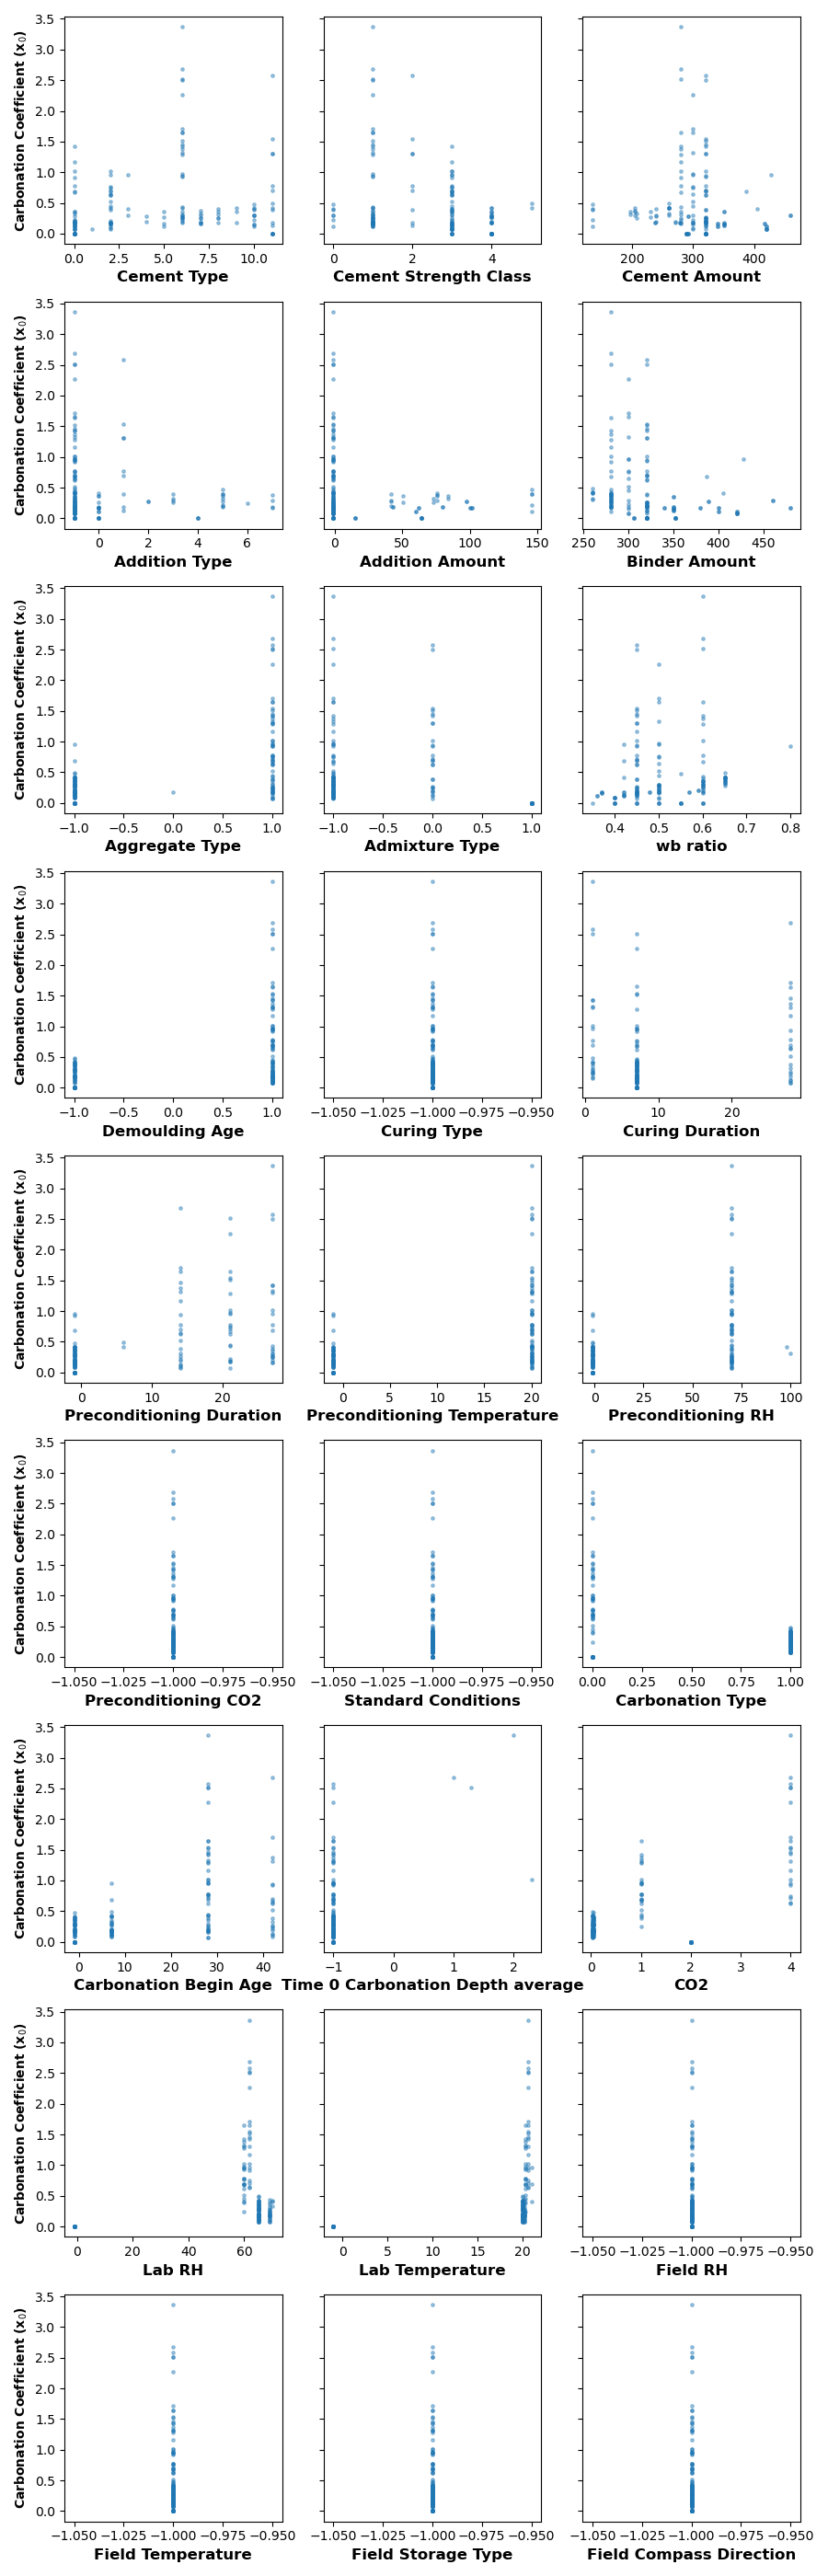

In [12]:
# view the pair correlations
num_cols = 3
num_rows = int( np.ceil((features.shape[1]-1)/ num_cols))
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,sharey=True,figsize=(9,28))
axs = axs.flatten()
for i,n in enumerate(np.array(features.keys()[1:])):
  ax = axs[i]
  ax.scatter(features[n], x_0_real['Carbonation Coefficient (x_0)'], s=6, alpha=0.4)
  if i % num_cols == 0:
    ax.set_ylabel("Carbonation Coefficient (x$_0$)", fontsize=10, fontweight="bold")
  #xlabel = n+" (kg/m$^3$ mixture)"
  #if i == 7:
    #xlabel = n+" (days)"
  ax.set_xlabel(n, fontsize=12, fontweight="bold")
  plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Index(['ID', 'Cement Type', 'Cement Strength Class', 'Cement Amount',
       'Addition Type', 'Addition Amount', 'Binder Amount', 'Aggregate Type',
       'Admixture Type', 'wb ratio', 'Demoulding Age', 'Curing Type',
       'Curing Duration', 'Preconditioning Duration',
       'Preconditioning Temperature', 'Preconditioning RH',
       'Preconditioning CO2', 'Standard Conditions', 'Carbonation Type',
       'Carbonation Begin Age', 'Time 0 Carbonation Depth average', 'CO2',
       'Lab RH', 'Lab Temperature', 'Field RH', 'Field Temperature',
       'Field Storage Type', 'Field Compass Direction', 'Cluster'],
      dtype='object')


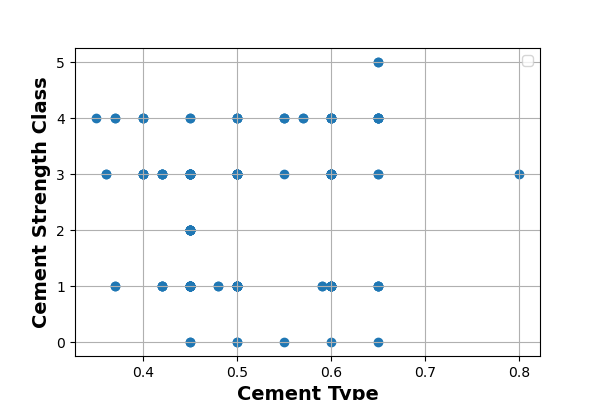

In [29]:
print(features.keys())
plt.figure(figsize=(6, 4))
plt.scatter(features['wb ratio'],features['Cement Strength Class'],marker="o", alpha = 1)


'''# Add 45-degree line for reference
min_depth = min(depth_time_test["Depth average [mm]"].min(), depth_time_test["Predicted Depth [mm]"].min())
max_depth = max(depth_time_test["Depth average [mm]"].max(), depth_time_test["Predicted Depth [mm]"].max())
plt.plot([min_depth, max_depth], [min_depth, max_depth], color="red", linestyle="--", label="Perfect Prediction")
'''
# Add labels and title
plt.xlabel("Cement Type", fontsize=14, fontweight="bold")
plt.ylabel("Cement Strength Class", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

# Drop ID column (not relevant for clustering or PCA) and most NaN features
features_data = features.drop(columns=['ID','Admixture Type','Curing Type','Preconditioning CO2', 'Standard Conditions','Field RH', 'Field Temperature', 'Field Storage Type',
       'Field Compass Direction'])
print(features_data)
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_data)
print(np.array(features_data.keys()))

     Cement Type  Cement Strength Class  Cement Amount  Addition Type  \
0            0.0                    4.0          320.0           -1.0   
1            0.0                    4.0          320.0           -1.0   
2            0.0                    4.0          320.0           -1.0   
3            0.0                    4.0          320.0           -1.0   
4            0.0                    4.0          320.0           -1.0   
..           ...                    ...            ...            ...   
147          6.0                    1.0          320.0           -1.0   
148          6.0                    1.0          320.0           -1.0   
149          6.0                    1.0          320.0           -1.0   
150          6.0                    1.0          320.0           -1.0   
151          7.0                    3.0          280.0            6.0   

     Addition Amount  Binder Amount  Aggregate Type  wb ratio  Demoulding Age  \
0               -1.0            320       

Explained Variance: [0.33934174 0.16542194 0.14002162]


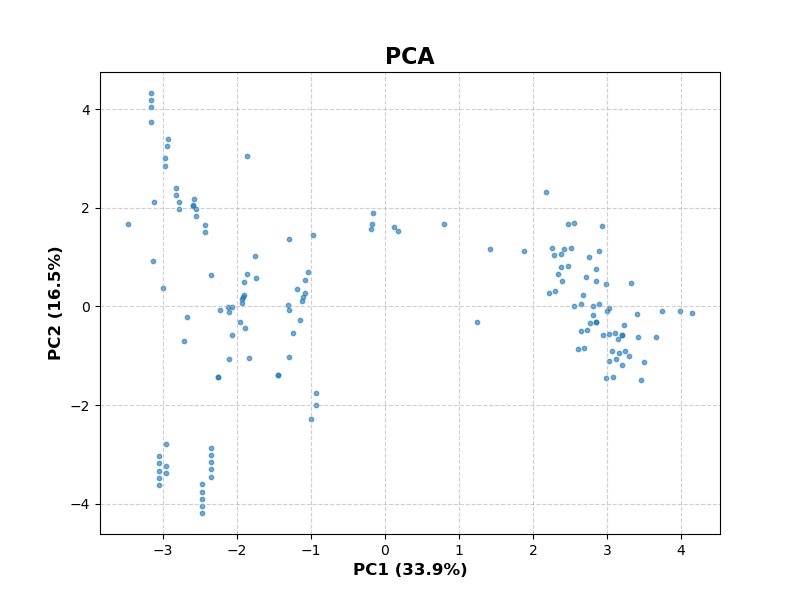

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Perform PCA
pca = PCA(n_components=3)  # Choose 2 for visualization, adjust as needed
pca_result = pca.fit_transform(features_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance:", explained_variance)

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10, alpha=0.6)
plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize = 12, fontweight="bold")
plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize = 12, fontweight="bold")
plt.title('PCA', fontsize = 16, fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [15]:
0.33934174+0.16542194+0.14002162

0.6447852999999999

In [16]:
# Feature contributions to the principal components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=np.array(features_data.keys())
)
print("Feature Loadings:\n", loadings)

Feature Loadings:
                                        PC1       PC2       PC3
Cement Type                       0.018994  0.207748 -0.099866
Cement Strength Class            -0.094901 -0.198520 -0.202032
Cement Amount                     0.043360 -0.341227  0.442386
Addition Type                    -0.167939  0.256842 -0.216970
Addition Amount                  -0.226651  0.244710 -0.126864
Binder Amount                    -0.129262 -0.228137  0.451526
Aggregate Type                    0.369767 -0.002274 -0.056923
wb ratio                          0.002263  0.248128 -0.337208
Demoulding Age                    0.307670  0.013699  0.197039
Curing Duration                   0.136673 -0.015431  0.006715
Preconditioning Duration          0.350442  0.031451 -0.064507
Preconditioning Temperature       0.368995  0.055419 -0.071724
Preconditioning RH                0.369021  0.026758 -0.061044
Carbonation Type                 -0.160711  0.374738  0.264636
Carbonation Begin Age             0.

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

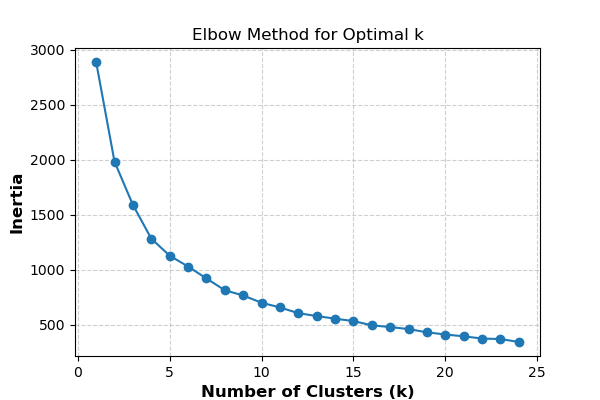

In [22]:
from sklearn.cluster import KMeans

# Determine optimal number of clusters using the Elbow method
inertia = []
k_values = range(1, 25)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)',fontsize = 12, fontweight="bold")
plt.ylabel('Inertia',fontsize = 12, fontweight="bold")
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
# Fit K-Means with optimal number of clusters (e.g., k=3)
kmeans = KMeans(n_clusters=19, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original DataFrame
features['Cluster'] = clusters

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


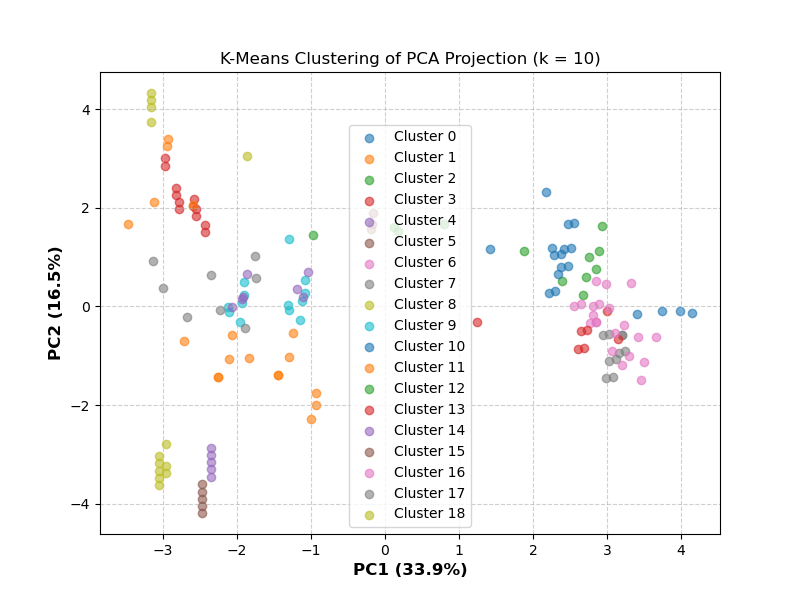

In [19]:
plt.figure(figsize=(8, 6))
for cluster in np.unique(clusters):
    plt.scatter(
        pca_result[clusters == cluster, 0],
        pca_result[clusters == cluster, 1],
        label=f'Cluster {cluster}', alpha=0.6
    )
plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize = 12, fontweight="bold")
plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize = 12, fontweight="bold")

plt.title('K-Means Clustering of PCA Projection (k = 10)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Correlation of PCs with Carbonation Coefficient:
 PC1    0.621258
PC2    0.008612
PC3   -0.199697
Name: Carbonation Coefficient (x_0), dtype: float64


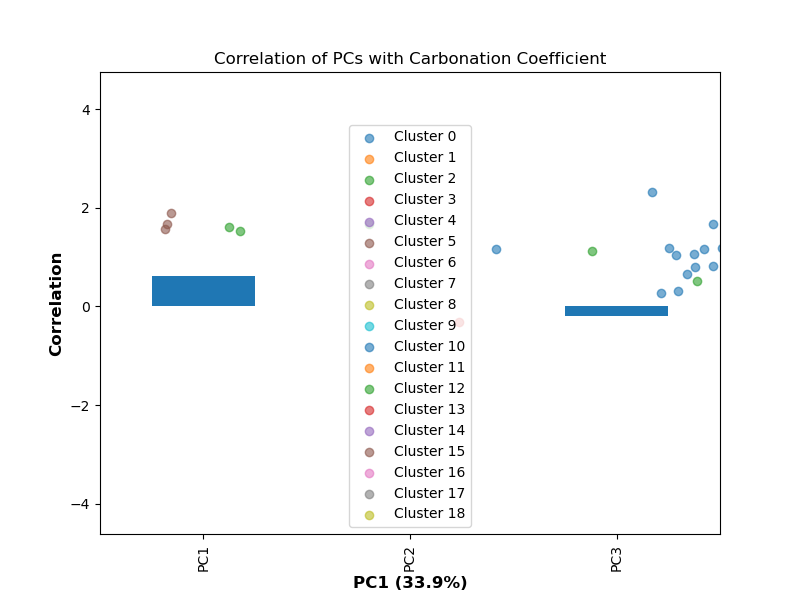

In [20]:
pc_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Add the label to the PC DataFrame
pc_df['Carbonation Coefficient (x_0)'] = x_0_real['Carbonation Coefficient (x_0)'].values

# Calculate pairwise correlations
correlations = pc_df.corr()['Carbonation Coefficient (x_0)'][:-1]  # Exclude self-correlation with the label
print("Correlation of PCs with Carbonation Coefficient:\n", correlations)

# Optional: Visualize the correlations
correlations.plot(kind='bar', title="Correlation of PCs with Carbonation Coefficient")
plt.ylabel("Correlation")
plt.show()

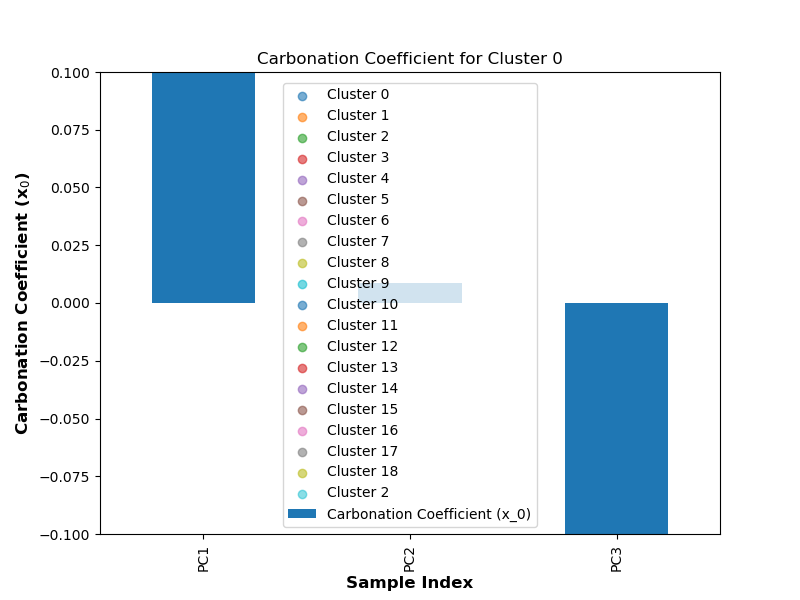

In [21]:
# Backtrack features for a specific cluster (e.g., Cluster 0)
cluster_2_indices = features[features['Cluster'] == 2].index
cluster_2_features = features.iloc[cluster_2_indices]
cluster_2_labels = x_0_real.iloc[cluster_2_indices]

# Visualize the carbonation coefficient for Cluster 0
plt.scatter(cluster_2_features.index, cluster_2_labels['Carbonation Coefficient (x_0)'], alpha=0.5, label="Cluster 2")
plt.ylim(-0.1,0.1)
plt.xlabel("Sample Index")
plt.ylabel("Carbonation Coefficient (x$_0$)")
plt.title("Carbonation Coefficient for Cluster 0")
plt.legend()
plt.show()

Principal Component Analysis is not effective for dimensionality reduction due to the minimal explained variance. 